In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, roc_curve, auc
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## Load the dataset

In [3]:
# Load the dataset
data = pd.read_csv('Dead by Daylight data.csv')
data.head()

,Map,Killer,Nb Finished generators,Nb Escaped Survivors,Comments,Nb Hatch escapes,Season,SBMM
0,BAP,Deathslinger,5,4,NaN,0,February,False
1,MCM,Cannibal,2,0,NaN,0,February,False
2,SH,Huntress,5,4,Farm,0,February,False
3,CF,Myers,3,0,Mori,0,February,False
4,AVW,Hillbilly,5,4,1 hatch,1,February,False


## Correlation study

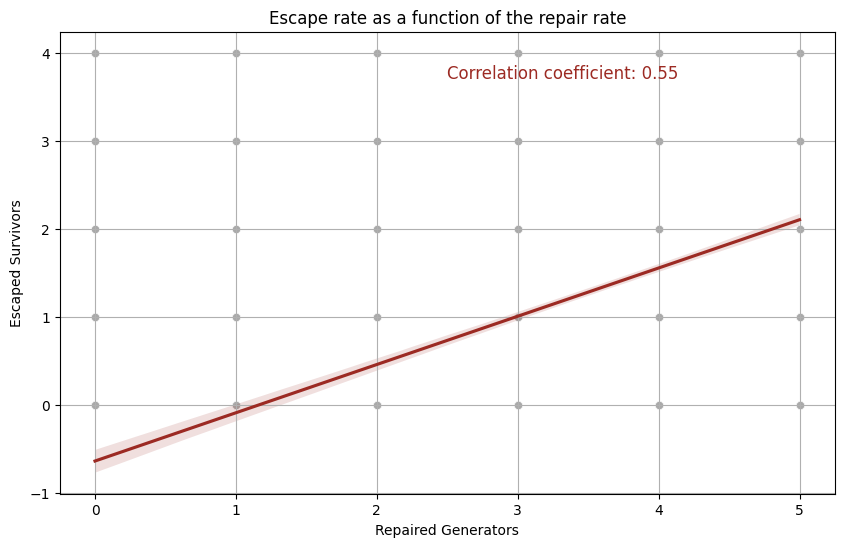

In [3]:
# Fit a linear regression model to get the slope
X = data['Nb Finished generators'].values.reshape(-1, 1)
y = data['Nb Escaped Survivors'].values
reg = LinearRegression().fit(X, y)
slope = reg.coef_[0]

# Create a scatter plot with a linear regression line
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Nb Finished generators', y='Nb Escaped Survivors', data=data, color='darkgray')
sns.regplot(x='Nb Finished generators', y='Nb Escaped Survivors', data=data, scatter=False, color='#9C2A23')

# Add grid
plt.grid(True)

# Add labels and title
plt.xlabel('Repaired Generators')
plt.ylabel('Escaped Survivors')
plt.title('Escape rate as a function of the repair rate')

# Annotate the plot with the slope value
plt.text(0.5, 0.9, f'Correlation coefficient: {slope:.2f}', transform=plt.gca().transAxes, fontsize=12, color='#9C2A23')

# Display the plot
plt.show()


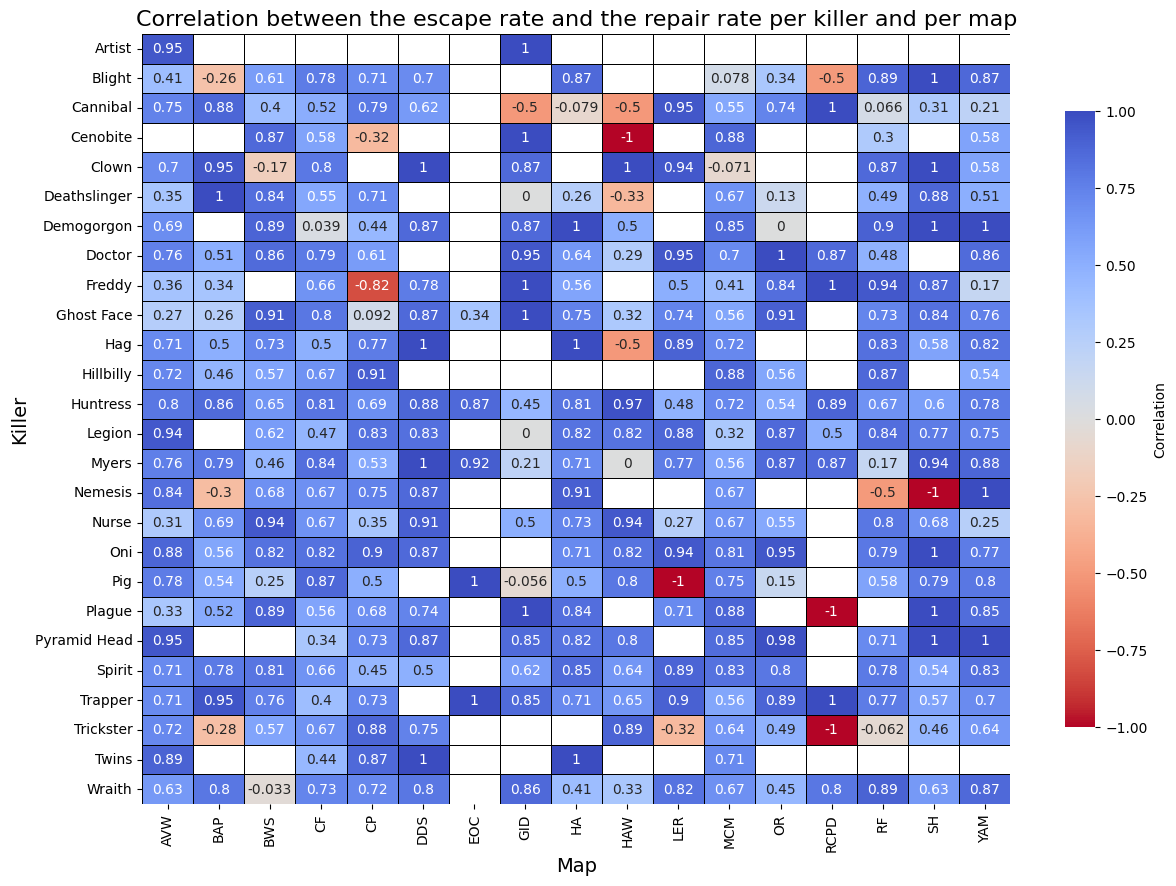

In [4]:
# Standardize the map names by stripping leading/trailing whitespace
data['Map'] = data['Map'].str.strip()

# Calculate Spearman correlation for each Killer and Map (Spearman correlation is more suited for ordinal data)
cor_data = data.groupby(['Killer', 'Map']).apply(
    lambda group: pd.Series({
        'Correlation': group['Nb Finished generators'].corr(group['Nb Escaped Survivors'], method='spearman')
    })
).reset_index()

# Create a pivot table for the heatmap
cor_pivot = cor_data.pivot(index='Killer', columns='Map', values='Correlation')

# Plotting the heatmap
plt.figure(figsize=(14, 10))
ax = sns.heatmap(cor_pivot, annot=True, cmap='coolwarm_r', center=0, 
                 cbar_kws={'label': 'Correlation', 'orientation': 'vertical', 'shrink': 0.8},
                 linewidths=.5, linecolor='black')

# Titles and labels
ax.set_title('Correlation between the escape rate and the repair rate per killer and per map', fontsize=16)
ax.set_xlabel('Map', fontsize=14)
ax.set_ylabel('Killer', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

# Add a grid
ax.set_yticks([i + 0.5 for i in range(len(cor_pivot))], minor=True)
ax.set_xticks([i + 0.5 for i in range(len(cor_pivot.columns))], minor=True)
ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
ax.tick_params(which='minor', size=0)

# Display the plot
plt.show()



## Escapes Prediction (Random Forest)

### In this first attempt, we try to predict the escape rate of a given round, based on the Map, the Killer, as well as the number of generators repaired. We thus take into account escapes through the exit gates as well as well as hatch escapes (which do not depend on the number of generators repaired).

Accuracy: 0.4670138888888889


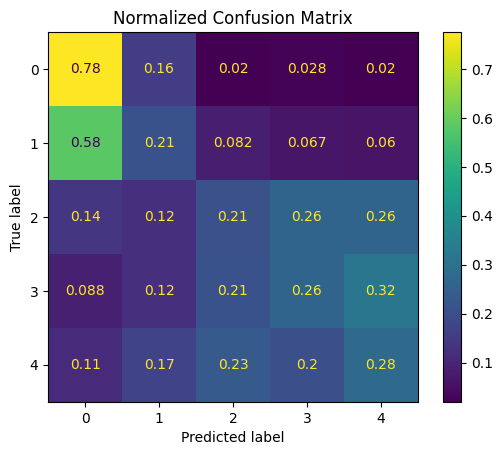

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.78      0.71       249
           1       0.30      0.21      0.25       134
           2       0.26      0.21      0.23        72
           3       0.24      0.26      0.25        57
           4       0.26      0.28      0.27        64

    accuracy                           0.47       576
   macro avg       0.34      0.35      0.34       576
weighted avg       0.44      0.47      0.45       576



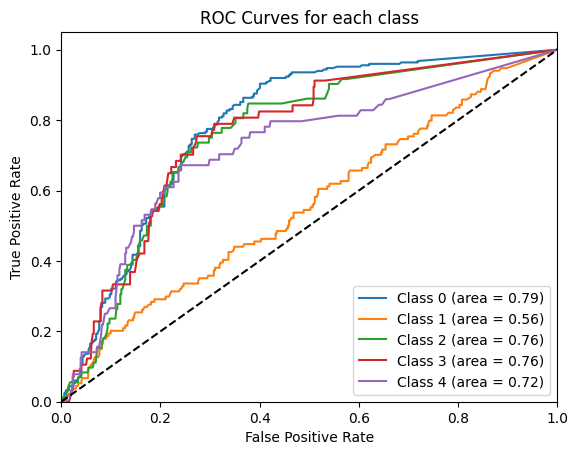

--- Example prediction ---
Given features: 
    Map  Killer  Nb Finished generators
471  CP  Spirit                       3
Predicted number of survivors escaping for this round: 0
Actual number of survivors escaping for this round: 1

--- Error analysis ---
In total 307 mistakes out of 576 samples


100%|██████████| 307/307 [00:00<00:00, 8632.34it/s]

Mistake 1:
Features: 
Map                           CP
Killer                    Spirit
Nb Finished generators         3
Name: 471, dtype: object
Actual: 1, Predicted: 0
--------------------------------------------------
Mistake 2:
Features: 
Map                           CF
Killer                    Wraith
Nb Finished generators         5
Name: 1453, dtype: object
Actual: 2, Predicted: 4
--------------------------------------------------
Mistake 3:
Features: 
Map                             SH
Killer                    Huntress
Nb Finished generators           5
Name: 2377, dtype: object
Actual: 0, Predicted: 4
--------------------------------------------------
Mistake 4:
Features: 
Map                          MCM
Killer                    Freddy
Nb Finished generators         5
Name: 1094, dtype: object
Actual: 4, Predicted: 1
--------------------------------------------------
Mistake 5:
Features: 
Map                           OR
Killer                    Spirit
Nb Finished generat

In [10]:
# Define features and target variable
features = data.drop(columns=['Nb Escaped Survivors', 'Comments', 'Nb Hatch escapes', 'SBMM', 'Season'])
target = data['Nb Escaped Survivors']

# Identify categorical columns
categorical_cols = features.select_dtypes(include=['object']).columns.tolist()

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

# Create the model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Confusion Matrix
class_names = np.arange(0, 5)
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)

# Normalize the confusion matrix (the supports are unbalanced, so this is allows for better interpretability)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_normalized, display_labels=class_names)
disp.plot(cmap='viridis')
plt.title('Normalized Confusion Matrix')
plt.show()

# Classification Report
print('Classification Report:')
print(classification_report(y_test, y_pred))

# ROC Curves for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in class_names:
    fpr[i], tpr[i], _ = roc_curve(y_test == i, model.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in class_names:
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for each class')
plt.legend(loc="lower right")
plt.show()

# Example prediction
example = X_test.iloc[0:1]
predicted_escapees = model.predict(example)
actual_escapees = y_test.iloc[0]
print(f'--- Example prediction ---')
print(f'Given features: \n{example}')
print(f'Predicted number of survivors escaping for this round: {predicted_escapees[0]}')
print(f'Actual number of survivors escaping for this round: {actual_escapees}')

# Error analysis
err = []
for i in range(len(y_test)):
    if y_test.iloc[i] != y_pred[i]:
        err.append(i)

print(f'\n--- Error analysis ---')
print(f'In total {len(err)} mistakes out of {len(y_test)} samples')

for i in tqdm(range(len(err))):
    index = err[i]
    print(f'Mistake {i+1}:')
    print(f'Features: \n{X_test.iloc[index]}')
    print(f'Actual: {y_test.iloc[index]}, Predicted: {y_pred[index]}')
    print('-' * 50)


## Exit Gate Escapes (only!) Prediction

### Since hatch escapes do not depend on the number of repaired generators, we figure they might skew the data and 'confuse' the model. We thus choose to remove them from our predictions, and only predict the number of survivors who escaped through the exit gates.

Accuracy: 0.6336283185840708


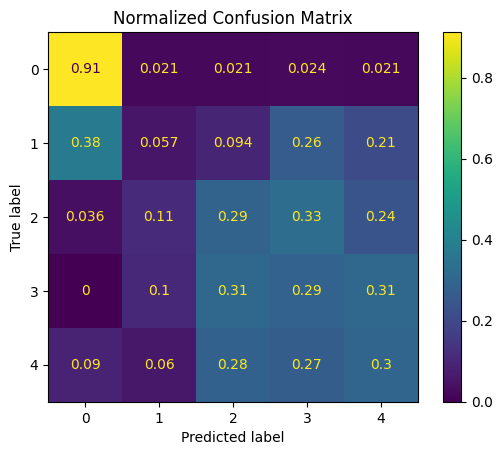

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.91       331
           1       0.12      0.06      0.08        53
           2       0.25      0.29      0.27        55
           3       0.23      0.29      0.25        59
           4       0.29      0.30      0.29        67

    accuracy                           0.63       565
   macro avg       0.36      0.37      0.36       565
weighted avg       0.63      0.63      0.63       565



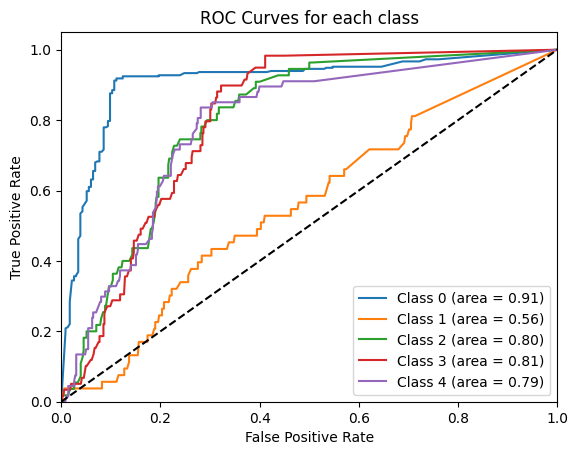

--- Example prediction ---
Given features: 
     Map Killer  Nb Finished generators
1112  SH  Myers                       5
Predicted number of survivors escaping through exit gates for this round: 4
Actual number of survivors escaping through exit gates for this round: 3

--- Error Analysis ---
In total 207 mistakes out of 565 samples


100%|██████████| 207/207 [00:00<00:00, 9137.05it/s]

Mistake 1:
Features: 
Map                          SH
Killer                    Myers
Nb Finished generators        5
Name: 1112, dtype: object
Actual: 3, Predicted: 4
--------------------------------------------------
Mistake 2:
Features: 
Map                             SH
Killer                    Huntress
Nb Finished generators           5
Name: 2377, dtype: object
Actual: 0, Predicted: 4
--------------------------------------------------
Mistake 3:
Features: 
Map                          AVW
Killer                    Artist
Nb Finished generators         5
Name: 2645, dtype: object
Actual: 2, Predicted: 4
--------------------------------------------------
Mistake 4:
Features: 
Map                           OR
Killer                    Blight
Nb Finished generators         5
Name: 1126, dtype: object
Actual: 4, Predicted: 3
--------------------------------------------------
Mistake 5:
Features: 
Map                            BWS
Killer                    Huntress
Nb Finished gener

In [23]:
# Create the new target variable: number of survivors escaping through exit gates
data['Nb Exit Gate Escapes'] = data['Nb Escaped Survivors'] - data['Nb Hatch escapes']

# Define features and target variable
features = data.drop(columns=['Nb Escaped Survivors', 'Nb Hatch escapes', 'Comments', 'SBMM', 'Season', 'Nb Exit Gate Escapes'])
target = data['Nb Exit Gate Escapes']

# Identify categorical columns
categorical_cols = features.select_dtypes(include=['object']).columns.tolist()

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

# Create the model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Confusion Matrix
class_names = np.arange(0, 5)
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)

# Normalize the confusion matrix (the supports are unbalanced, so this is allows for better interpretability)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_normalized, display_labels=class_names)
disp.plot(cmap='viridis')
plt.title('Normalized Confusion Matrix')
plt.show()

# Classification Report
print('Classification Report:')
print(classification_report(y_test, y_pred))

# ROC Curves for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in class_names:
    fpr[i], tpr[i], _ = roc_curve(y_test == i, model.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in class_names:
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for each class')
plt.legend(loc="lower right")
plt.show()

# Example prediction
example = X_test.iloc[0:1]
predicted_exit_gate_escapes = model.predict(example)
actual_exit_gate_escapes = y_test.iloc[0]
print(f'--- Example prediction ---')
print(f'Given features: \n{example}')
print(f'Predicted number of survivors escaping through exit gates for this round: {predicted_exit_gate_escapes[0]}')
print(f'Actual number of survivors escaping through exit gates for this round: {actual_exit_gate_escapes}')

# Error analysis
err = []
for i in range(len(y_test)):
    if y_test.iloc[i] != y_pred[i]:
        err.append(i)

print(f'\n--- Error Analysis ---')
print(f'In total {len(err)} mistakes out of {len(y_test)} samples')

for i in tqdm(range(len(err))):
    index = err[i]
    print(f'Mistake {i+1}:')
    print(f'Features: \n{X_test.iloc[index]}')
    print(f'Actual: {y_test.iloc[index]}, Predicted: {y_pred[index]}')
    print('-' * 50)


## Exit Gates (only!) escapes prediction with 'Killer DC' filtering (RF Classifier)

### In another attempt to improve our model, we also take into account the fact that when a Killer disconnects from the match, we count it as a 4-survivors escape into our dataset, which again skews the data as the number of generators repaired didn't play a role in this escape. We thus filter the data and remove all the entries where a Killer disconnect (indicated in the Comments by 'Killer DC')

Accuracy: 0.6336283185840708


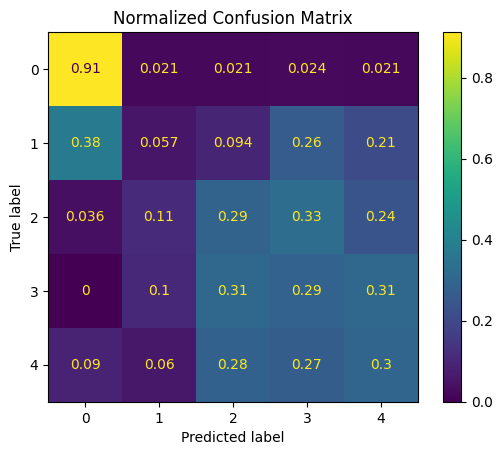

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.91       331
           1       0.12      0.06      0.08        53
           2       0.25      0.29      0.27        55
           3       0.23      0.29      0.25        59
           4       0.29      0.30      0.29        67

    accuracy                           0.63       565
   macro avg       0.36      0.37      0.36       565
weighted avg       0.63      0.63      0.63       565



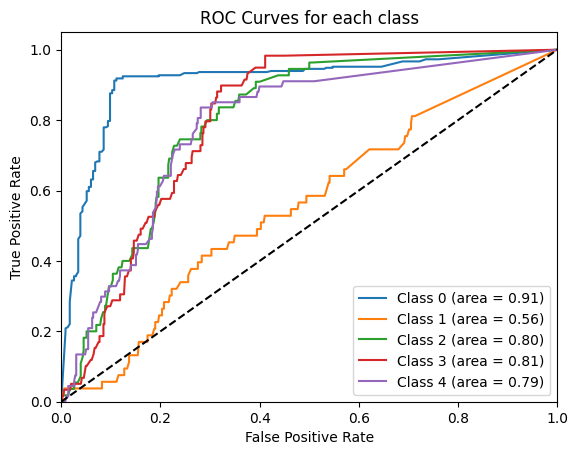

--- Example prediction ---
Given features: 
     Map Killer  Nb Finished generators
1112  SH  Myers                       5
Predicted number of survivors escaping through exit gates for this round: 4
Actual number of survivors escaping through exit gates for this round: 3

--- Error analysis ---
In total 207 mistakes out of 565 samples


100%|██████████| 207/207 [00:00<00:00, 8469.70it/s]

Mistake 1:
Features: 
Map                          SH
Killer                    Myers
Nb Finished generators        5
Name: 1112, dtype: object
Actual: 3, Predicted: 4
--------------------------------------------------
Mistake 2:
Features: 
Map                             SH
Killer                    Huntress
Nb Finished generators           5
Name: 2377, dtype: object
Actual: 0, Predicted: 4
--------------------------------------------------
Mistake 3:
Features: 
Map                          AVW
Killer                    Artist
Nb Finished generators         5
Name: 2645, dtype: object
Actual: 2, Predicted: 4
--------------------------------------------------
Mistake 4:
Features: 
Map                           OR
Killer                    Blight
Nb Finished generators         5
Name: 1126, dtype: object
Actual: 4, Predicted: 3
--------------------------------------------------
Mistake 5:
Features: 
Map                            BWS
Killer                    Huntress
Nb Finished gener

In [12]:
# Filter out matches where 'Comments' contains 'Killer DC'
data = data[~data['Comments'].str.contains('Killer DC', na=False)]

# Create the new target variable: number of survivors escaping through exit gates
data['Nb Exit Gate Escapes'] = data['Nb Escaped Survivors'] - data['Nb Hatch escapes']

# Define features and target variable
features = data.drop(columns=['Nb Escaped Survivors', 'Nb Hatch escapes', 'Comments', 'SBMM', 'Season', 'Nb Exit Gate Escapes'])
target = data['Nb Exit Gate Escapes']

# Identify categorical columns
categorical_cols = features.select_dtypes(include=['object']).columns.tolist()

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

# Create the model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Confusion Matrix
class_names = np.arange(0, 5)
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)

# Normalize the confusion matrix (the supports are unbalanced, so this is allows for better interpretability)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_normalized, display_labels=class_names)
disp.plot(cmap='viridis')
plt.title('Normalized Confusion Matrix')
plt.show()

# Classification Report
print('Classification Report:')
print(classification_report(y_test, y_pred))

# ROC Curves for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in class_names:
    fpr[i], tpr[i], _ = roc_curve(y_test == i, model.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in class_names:
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for each class')
plt.legend(loc="lower right")
plt.show()

# Example prediction
example = X_test.iloc[0:1]
predicted_exit_gate_escapes = model.predict(example)
actual_exit_gate_escapes = y_test.iloc[0]
print(f'--- Example prediction ---')
print(f'Given features: \n{example}')
print(f'Predicted number of survivors escaping through exit gates for this round: {predicted_exit_gate_escapes[0]}')
print(f'Actual number of survivors escaping through exit gates for this round: {actual_exit_gate_escapes}')

# Error analysis
err = []
for i in range(len(y_test)):
    if y_test.iloc[i] != y_pred[i]:
        err.append(i)

print(f'\n--- Error analysis ---')
print(f'In total {len(err)} mistakes out of {len(y_test)} samples')

for i in tqdm(range(len(err))):
    index = err[i]
    print(f'Mistake {i+1}:')
    print(f'Features: \n{X_test.iloc[index]}')
    print(f'Actual: {y_test.iloc[index]}, Predicted: {y_pred[index]}')
    print('-' * 50)


## Exit Gates (only!) escapes prediction with 'Killer DC' filtering (RF Classifier) with Grid Search

### We just obtained the most satisfying results so far by looking at the escapes through the exit gates only, and filtering out the Killer DCs. We now want to try to improve further our results by tuning the hyperparameters of our Random Forest Classifier. In order to do so, we apply Cross-Validation and Grid Search.

Best parameters: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Best score: 0.7073926181739694
Accuracy: 0.6938053097345133


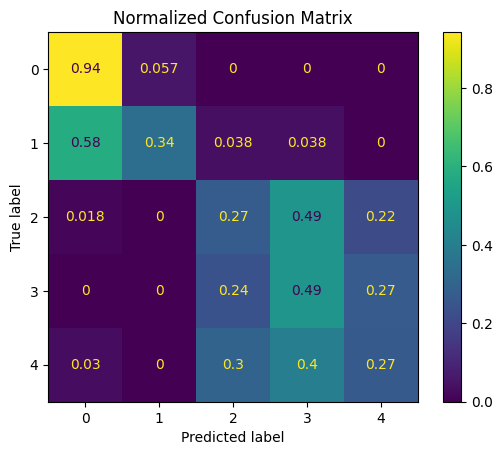

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       331
           1       0.49      0.34      0.40        53
           2       0.29      0.27      0.28        55
           3       0.34      0.49      0.40        59
           4       0.39      0.27      0.32        67

    accuracy                           0.69       565
   macro avg       0.48      0.46      0.47       565
weighted avg       0.68      0.69      0.68       565



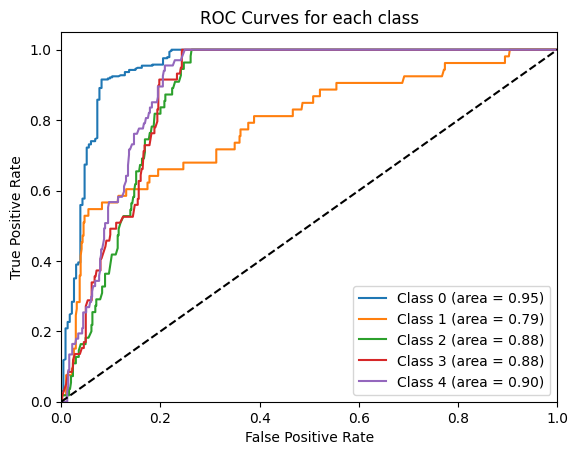

--- Example prediction ---
Given features: 
     Map Killer  Nb Finished generators  Win (S)
1112  SH  Myers                       5        1
Predicted number of survivors escaping through exit gates for this round: 2
Actual number of survivors escaping through exit gates for this round: 3

--- Error analysis ---
In total 173 mistakes out of 565 samples


100%|██████████| 173/173 [00:00<00:00, 8617.24it/s]

Mistake 1:
Features: 
Map                          SH
Killer                    Myers
Nb Finished generators        5
Win (S)                       1
Name: 1112, dtype: object
Actual: 3, Predicted: 2
--------------------------------------------------
Mistake 2:
Features: 
Map                             SH
Killer                    Huntress
Nb Finished generators           5
Win (S)                          0
Name: 2377, dtype: object
Actual: 0, Predicted: 1
--------------------------------------------------
Mistake 3:
Features: 
Map                          AVW
Killer                    Artist
Nb Finished generators         5
Win (S)                        1
Name: 2645, dtype: object
Actual: 2, Predicted: 3
--------------------------------------------------
Mistake 4:
Features: 
Map                           OR
Killer                    Blight
Nb Finished generators         5
Win (S)                        1
Name: 1126, dtype: object
Actual: 4, Predicted: 3
---------------------------

In [32]:
# Filter out matches where 'Comments' contains 'Killer DC'
data = data[~data['Comments'].str.contains('Killer DC', na=False)]

# Create the new target variable: number of survivors escaping through exit gates
data['Nb Exit Gate Escapes'] = data['Nb Escaped Survivors'] - data['Nb Hatch escapes']

# Define features and target variable
features = data.drop(columns=['Nb Escaped Survivors', 'Nb Hatch escapes', 'Comments', 'SBMM', 'Season', 'Nb Exit Gate Escapes'])
target = data['Nb Exit Gate Escapes']

# Identify categorical columns
categorical_cols = features.select_dtypes(include=['object']).columns.tolist()

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

# Create the model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Define the hyperparameters grid for RandomForestClassifier
param_grid = {
    'classifier__n_estimators': [50, 100, 200], # number of trees in the forest
    'classifier__max_depth': [None, 10, 20, 30], # max number of levels in each decision tree
    'classifier__min_samples_split': [2, 5, 10], # min number of data points placed in a node before the node is split
    'classifier__min_samples_leaf': [1, 2, 4] # min number of data points allowed in a leaf node
}

# Perform GridSearchCV to find the best parameters
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
# n_jobs = -1 -> using all processors

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train the model using GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Output the best parameters and score
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_}')

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Confusion Matrix
class_names = np.arange(0, 5)
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)

# Normalize the confusion matrix (the supports are unbalanced, so this is allows for better interpretability)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_normalized, display_labels=class_names)
disp.plot(cmap='viridis')
plt.title('Normalized Confusion Matrix')
plt.show()

# Classification Report
print('Classification Report:')
print(classification_report(y_test, y_pred))

# ROC Curves for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in class_names:
    fpr[i], tpr[i], _ = roc_curve(y_test == i, best_model.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in class_names:
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for each class')
plt.legend(loc="lower right")
plt.show()

# Example prediction
example = X_test.iloc[0:1]
predicted_exit_gate_escapes = best_model.predict(example)
actual_exit_gate_escapes = y_test.iloc[0]
print(f'--- Example prediction ---')
print(f'Given features: \n{example}')
print(f'Predicted number of survivors escaping through exit gates for this round: {predicted_exit_gate_escapes[0]}')
print(f'Actual number of survivors escaping through exit gates for this round: {actual_exit_gate_escapes}')

# Error analysis
err = []
for i in range(len(y_test)):
    if y_test.iloc[i] != y_pred[i]:
        err.append(i)

print(f'\n--- Error analysis ---')
print(f'In total {len(err)} mistakes out of {len(y_test)} samples')

for i in tqdm(range(len(err))):
    index = err[i]
    print(f'Mistake {i+1}:')
    print(f'Features: \n{X_test.iloc[index]}')
    print(f'Actual: {y_test.iloc[index]}, Predicted: {y_pred[index]}')
    print('-' * 50)


## Exit Gates (only!) escapes prediction with 'Killer DC' filtering using SVM (with Grid Search)

### To better handle the complexity of the dataset, we now try to use Support Vector Machines. Indeed, we notice that the misclassifications we obtained using Random Forests were usually between two classes close to one another (predict 1 escape instead of 0, etc.). We figure that using SVM, and plotting the data into high dimensions will allow us to distinguish those close cases better.

Best parameters: {'classifier__C': 1, 'classifier__gamma': 'scale', 'classifier__kernel': 'poly'}
Best score: 0.7073877126542787
Accuracy: 0.6973451327433628


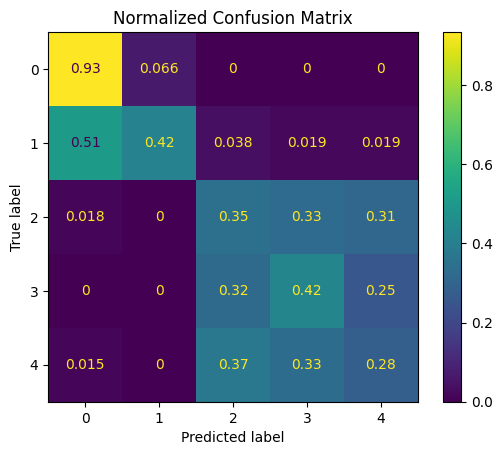

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       331
           1       0.50      0.42      0.45        53
           2       0.29      0.35      0.32        55
           3       0.38      0.42      0.40        59
           4       0.37      0.28      0.32        67

    accuracy                           0.70       565
   macro avg       0.49      0.48      0.48       565
weighted avg       0.69      0.70      0.69       565



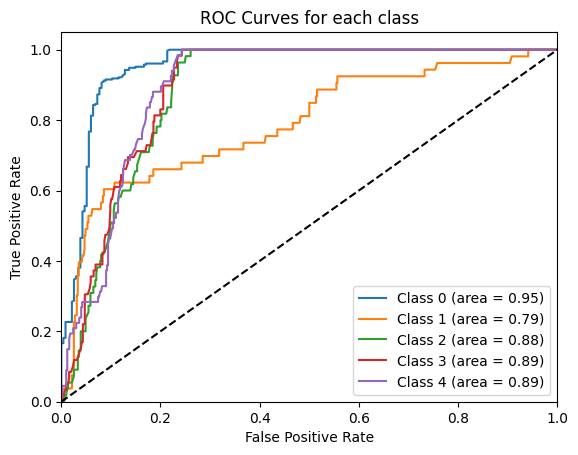

--- Example prediction ---
Given features: 
     Map Killer  Nb Finished generators  Win (S)
1112  SH  Myers                       5        1
Predicted number of survivors escaping through exit gates for this round: 2
Actual number of survivors escaping through exit gates for this round: 3

 --- Error Analysis ---
In total 171 mistakes out of 565 samples


100%|██████████| 171/171 [00:00<00:00, 8908.98it/s]

Mistake 1:
Features: 
Map                          SH
Killer                    Myers
Nb Finished generators        5
Win (S)                       1
Name: 1112, dtype: object
Actual: 3, Predicted: 2
--------------------------------------------------
Mistake 2:
Features: 
Map                             SH
Killer                    Huntress
Nb Finished generators           5
Win (S)                          0
Name: 2377, dtype: object
Actual: 0, Predicted: 1
--------------------------------------------------
Mistake 3:
Features: 
Map                          AVW
Killer                    Artist
Nb Finished generators         5
Win (S)                        1
Name: 2645, dtype: object
Actual: 2, Predicted: 4
--------------------------------------------------
Mistake 4:
Features: 
Map                           OR
Killer                    Blight
Nb Finished generators         5
Win (S)                        1
Name: 1126, dtype: object
Actual: 4, Predicted: 3
---------------------------

In [30]:
# Filter out matches where 'Comments' contains 'Killer DC'
data = data[~data['Comments'].str.contains('Killer DC', na=False)]

# Create the new target variable: number of survivors escaping through exit gates
data['Nb Exit Gate Escapes'] = data['Nb Escaped Survivors'] - data['Nb Hatch escapes']

# Define features and target
features = data.drop(columns=['Nb Escaped Survivors', 'Nb Hatch escapes', 'Comments', 'SBMM', 'Season', 'Nb Exit Gate Escapes'])
target = data['Nb Exit Gate Escapes']

# Identify categorical columns
categorical_cols = features.select_dtypes(include=['object']).columns.tolist()

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), features.select_dtypes(include=['number']).columns.tolist())
    ],
    remainder='passthrough'
)

# Define the model pipeline with SVC
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(probability=True))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Define the hyperparameters grid for SVC
param_grid = {
    'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'], # types of kernels
    'classifier__C': [0.1, 1, 10, 100], # regularization parameter
    'classifier__gamma': ['scale', 'auto'] # kernel coefficient for ‘poly’, ‘rbf’ and ‘sigmoid’.
}

# Perform GridSearchCV to find the best parameters
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Output the best parameters and score
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_}')

# Use the best estimator to make predictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Confusion Matrix’’
class_names = np.arange(0, 5)
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)

# Normalize the confusion matrix (the supports are unbalanced, so this is allows for better interpretability)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_normalized, display_labels=class_names)
disp.plot(cmap='viridis')
plt.title('Normalized Confusion Matrix')
plt.show()

# Classification Report
print('Classification Report:')
print(classification_report(y_test, y_pred))

# ROC Curves for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in class_names:
    fpr[i], tpr[i], _ = roc_curve(y_test == i, best_model.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in class_names:
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for each class')
plt.legend(loc="lower right")
plt.show()

# Example prediction
example = X_test.iloc[0:1]
predicted_exit_gate_escapes = best_model.predict(example)
actual_exit_gate_escapes = y_test.iloc[0]
print(f'--- Example prediction ---')
print(f'Given features: \n{example}')
print(f'Predicted number of survivors escaping through exit gates for this round: {predicted_exit_gate_escapes[0]}')
print(f'Actual number of survivors escaping through exit gates for this round: {actual_exit_gate_escapes}')

# Error analysis
err = []
for i in range(len(y_test)):
    if y_test.iloc[i] != y_pred[i]:
        err.append(i)

print(f'\n --- Error Analysis ---')
print(f'In total {len(err)} mistakes out of {len(y_test)} samples')

for i in tqdm(range(len(err))):
    index = err[i]
    print(f'Mistake {i+1}:')
    print(f'Features: \n{X_test.iloc[index]}')
    print(f'Actual: {y_test.iloc[index]}, Predicted: {y_pred[index]}')
    print('-' * 50)


## Cost-sensitive SVM

### Since the support of the classes are very unbalanced (331 for '0', between 53 and 67 for '1' to '4'), we attempt to use a Cost-senstitive SVC, that will normalize the data and take into account that problematic unbalance.

Best parameters: {'classifier__C': 1, 'classifier__gamma': 'scale', 'classifier__kernel': 'poly'}
Best score: 0.695880344563703
Accuracy: 0.6884955752212389


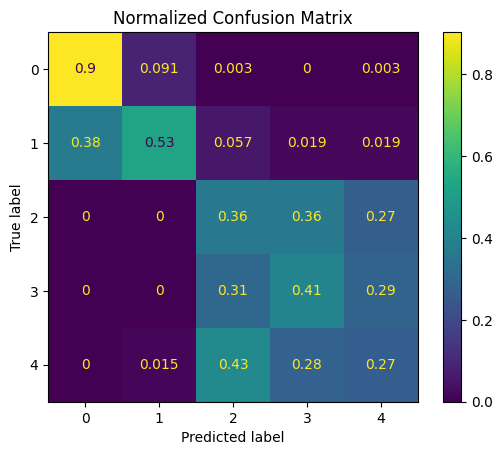

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       331
           1       0.47      0.53      0.50        53
           2       0.28      0.36      0.32        55
           3       0.38      0.41      0.39        59
           4       0.35      0.27      0.30        67

    accuracy                           0.69       565
   macro avg       0.48      0.49      0.49       565
weighted avg       0.70      0.69      0.69       565



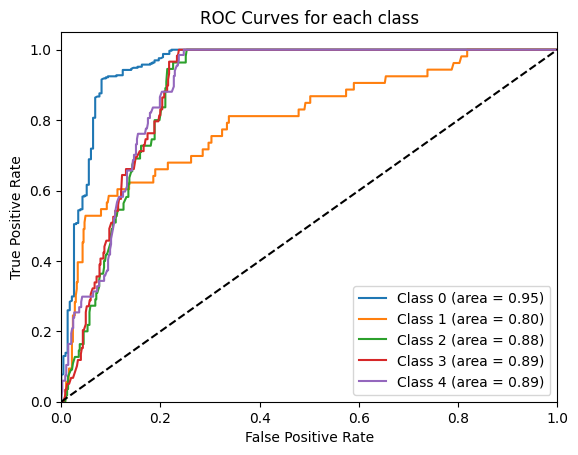

--- Example Prediction ---
Given features: 
     Map Killer  Nb Finished generators  Win (S)
1112  SH  Myers                       5        1
Predicted number of survivors escaping through exit gates for this round: 4
Actual number of survivors escaping through exit gates for this round: 3

--- Error Analysis ---
In total 176 mistakes out of 565 samples


100%|██████████| 176/176 [00:00<00:00, 8373.29it/s]

Mistake 1:
Features: 
Map                          SH
Killer                    Myers
Nb Finished generators        5
Win (S)                       1
Name: 1112, dtype: object
Actual: 3, Predicted: 4
--------------------------------------------------
Mistake 2:
Features: 
Map                             SH
Killer                    Huntress
Nb Finished generators           5
Win (S)                          0
Name: 2377, dtype: object
Actual: 0, Predicted: 1
--------------------------------------------------
Mistake 3:
Features: 
Map                          AVW
Killer                    Artist
Nb Finished generators         5
Win (S)                        1
Name: 2645, dtype: object
Actual: 2, Predicted: 4
--------------------------------------------------
Mistake 4:
Features: 
Map                           OR
Killer                    Blight
Nb Finished generators         5
Win (S)                        1
Name: 1126, dtype: object
Actual: 4, Predicted: 3
---------------------------

In [29]:
# Filter out matches where 'Comments' contains 'Killer DC'
data = data[~data['Comments'].str.contains('Killer DC', na=False)]

# Create the new target variable: number of survivors escaping through exit gates
data['Nb Exit Gate Escapes'] = data['Nb Escaped Survivors'] - data['Nb Hatch escapes']

# Define features and target
features = data.drop(columns=['Nb Escaped Survivors', 'Nb Hatch escapes', 'Comments', 'SBMM', 'Season', 'Nb Exit Gate Escapes'])
target = data['Nb Exit Gate Escapes']

# Identify categorical columns
categorical_cols = features.select_dtypes(include=['object']).columns.tolist()

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), features.select_dtypes(include=['number']).columns.tolist())
    ],
    remainder='passthrough'
)

# Define the model pipeline with cost-sensitive SVC
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(probability=True, class_weight='balanced'))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Define parameter grid for GridSearchCV
param_grid = {
    'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'], # types of kernels
    'classifier__C': [0.1, 1, 10, 100], # regularization parameter
    'classifier__gamma': ['scale', 'auto'] # kernel coefficient for ‘poly’, ‘rbf’ and ‘sigmoid’.
}

# Perform GridSearchCV to find the best parameters
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Output the best parameters and score
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_}')

# Use the best estimator to make predictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Confusion Matrix
class_names = np.arange(0, 5)
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)

# Normalize the confusion matrix (the supports are unbalanced, so this is allows for better interpretability)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_normalized, display_labels=class_names)
disp.plot(cmap='viridis')
plt.title('Normalized Confusion Matrix')
plt.show()

# Classification Report
print('Classification Report:')
print(classification_report(y_test, y_pred))

# ROC Curves for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in class_names:
    fpr[i], tpr[i], _ = roc_curve(y_test == i, best_model.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in class_names:
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for each class')
plt.legend(loc="lower right")
plt.show()

# Example prediction
example = X_test.iloc[0:1]
predicted_exit_gate_escapes = best_model.predict(example)
actual_exit_gate_escapes = y_test.iloc[0]
print(f'--- Example Prediction ---')
print(f'Given features: \n{example}')
print(f'Predicted number of survivors escaping through exit gates for this round: {predicted_exit_gate_escapes[0]}')
print(f'Actual number of survivors escaping through exit gates for this round: {actual_exit_gate_escapes}')

# Error analysis
err = []
for i in range(len(y_test)):
    if y_test.iloc[i] != y_pred[i]:
        err.append(i)

print(f'\n--- Error Analysis ---')
print(f'In total {len(err)} mistakes out of {len(y_test)} samples')

for i in tqdm(range(len(err))):
    index = err[i]
    print(f'Mistake {i+1}:')
    print(f'Features: \n{X_test.iloc[index]}')
    print(f'Actual: {y_test.iloc[index]}, Predicted: {y_pred[index]}')
    print('-' * 50)


## Binary Classification : Win or Loss (using SVM and grid search). Killer DC filtered.

In [28]:
# Filter out matches where 'Comments' contains 'Killer DC'
data = data[~data['Comments'].str.contains('Killer DC', na=False)]

# Create the new target variable: win for killer (0) or win for survivors (1)
data['Win (S)'] = np.where(data['Nb Escaped Survivors'] <= 1, 0, 1)

data.head()

,Map,Killer,Nb Finished generators,Nb Escaped Survivors,Comments,Nb Hatch escapes,Season,SBMM,Nb Exit Gate Escapes,Win (S)
0,BAP,Deathslinger,5,4,NaN,0,February,False,4,1
1,MCM,Cannibal,2,0,NaN,0,February,False,0,0
2,SH,Huntress,5,4,Farm,0,February,False,4,1
3,CF,Myers,3,0,Mori,0,February,False,0,0
4,AVW,Hillbilly,5,4,1 hatch,1,February,False,3,1


### Note that in this case, we do not use base our predictions on the number of survivors who escaped though the exit gates only, as in some cases, 2 people are going to escape, 1 though the gates and one possibly through the hatch. In cases like this, not considering hatch escapes would actually rig our predictions.

Accuracy: 0.9805309734513274


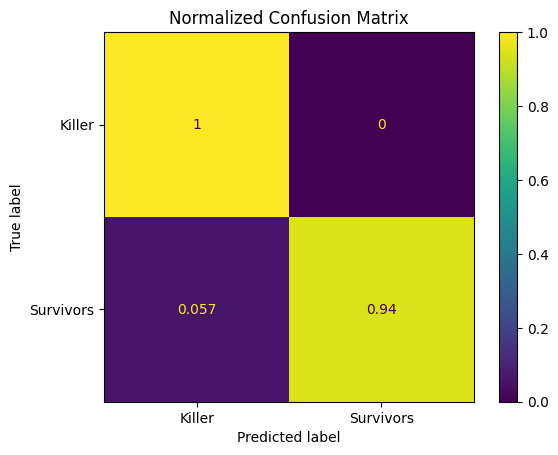

Classification Report:
              precision    recall  f1-score   support

      Killer       0.97      1.00      0.99       373
   Survivors       1.00      0.94      0.97       192

    accuracy                           0.98       565
   macro avg       0.99      0.97      0.98       565
weighted avg       0.98      0.98      0.98       565

--- Example prediction ---
Given features: 
     Map Killer  Nb Finished generators  Nb Exit Gate Escapes
1112  SH  Myers                       5                     3
Predicted win (0: Killer, 1: Survivors) for this round: 1
Actual win (0: Killer, 1: Survivors) for this round: 1

--- Error analysis ---
In total 11 mistakes out of 565 samples


100%|██████████| 11/11 [00:00<00:00, 3701.35it/s]

Mistake 1:
Features: 
Map                                MCM
Killer                    Pyramid Head
Nb Finished generators               4
Nb Exit Gate Escapes                 0
Name: 1763, dtype: object
Actual: 1, Predicted: 0
--------------------------------------------------
Mistake 2:
Features: 
Map                             YAM
Killer                    Trickster
Nb Finished generators            4
Nb Exit Gate Escapes              1
Name: 480, dtype: object
Actual: 1, Predicted: 0
--------------------------------------------------
Mistake 3:
Features: 
Map                            BAP
Killer                    Cannibal
Nb Finished generators           4
Nb Exit Gate Escapes             0
Name: 578, dtype: object
Actual: 1, Predicted: 0
--------------------------------------------------
Mistake 4:
Features: 
Map                          DDS
Killer                    Plague
Nb Finished generators         4
Nb Exit Gate Escapes           1
Name: 906, dtype: object
Actual: 1, Pre

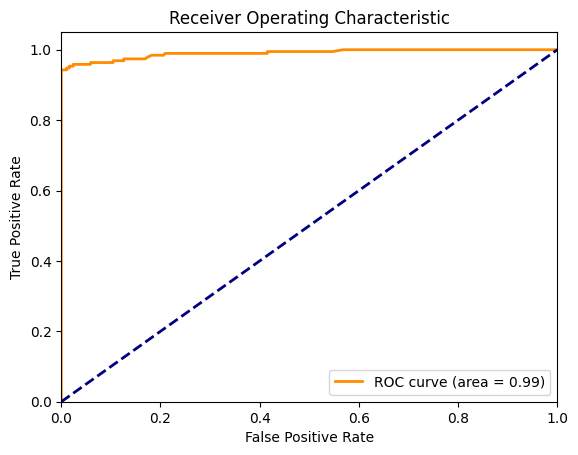

In [31]:
# Filter out matches where 'Comments' contains 'Killer DC'
data = data[~data['Comments'].str.contains('Killer DC', na=False)]

# Create the new target variable: win for survivors (1) or win for killer (0)
data['Win (S)'] = np.where(data['Nb Escaped Survivors'] <= 1, 0, 1)

# Define features and target
features = data.drop(columns=['Nb Escaped Survivors', 'Nb Hatch escapes', 'SBMM', 'Season', 'Comments', 'Win (S)'])
target = data['Win (S)']

# Identify categorical columns
categorical_cols = features.select_dtypes(include=['object']).columns.tolist()

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), features.select_dtypes(include=['number']).columns.tolist())
    ],
    remainder='passthrough'
)

# Create the model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(probability=True))
])

# Define the hyperparameters grid for SVC
param_grid = {
    'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__gamma': ['scale', 'auto']
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train the model using GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Confusion Matrix
class_names = ['Killer', 'Survivors']
conf_matrix = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix (the supports are unbalanced, so this is allows for better interpretability)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_normalized, display_labels=class_names)
disp.plot(cmap='viridis')
plt.title('Normalized Confusion Matrix')
plt.show()

# Classification Report
print('Classification Report:')
print(classification_report(y_test, y_pred, target_names=class_names))

# Example prediction
example = X_test.iloc[0:1]
predicted_win = best_model.predict(example)
actual_win = y_test.iloc[0]
print(f'--- Example prediction ---')
print(f'Given features: \n{example}')
print(f'Predicted win (0: Killer, 1: Survivors) for this round: {predicted_win[0]}')
print(f'Actual win (0: Killer, 1: Survivors) for this round: {actual_win}')

# Error analysis
err = []
for i in range(len(y_test)):
    if y_test.iloc[i] != y_pred[i]:
        err.append(i)

print(f'\n--- Error analysis ---')
print(f'In total {len(err)} mistakes out of {len(y_test)} samples')

for i in tqdm(range(len(err))):
    index = err[i]
    print(f'Mistake {i+1}:')
    print(f'Features: \n{X_test.iloc[index]}')
    print(f'Actual: {y_test.iloc[index]}, Predicted: {y_pred[index]}')
    print('-' * 50)

# Plot ROC Curve
y_prob = best_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


Add performance analysis

Correlation analysis for seasons/SBMM

add limitations

explain choices of algorithms


DEAL WITH INBALANCE IN LAST BINARY PREDICTION

NOTE DOWN TOTAL NB MISTAKES EVERY TIME

(PCA)